In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

# model
from sklearn.ensemble import RandomForestRegressor

SEED=42

In [3]:
path = 'drive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'train'),'\n', 
      os.listdir(path + 'test'),'\n', 
#       os.listdir(path + '../metrics'),'\n', 
      os.listdir(path + '../scripts'))

['train_payment.csv', 'train_trade.csv', 'train_pledge.csv', 'train_combat.csv', 'train_label.csv', 'train_activity.csv', 'train_merge_bjw.csv'] 
 ['test1_activity.csv', 'test1_combat.csv', 'test2_activity.csv', 'test1_pledge.csv', 'test2_combat.csv', 'test2_trade.csv', 'test1_trade.csv', 'test1_payment.csv', 'test2_payment.csv', 'test2_pledge.csv'] 
 ['explortary data', 'model', 'data merge']


In [0]:
train_label = pd.read_csv(path + 'train/train_label.csv')
train_activity = pd.read_csv(path + 'train/train_activity.csv')
#train_combat = pd.read_csv(path + 'train/train_combat.csv')
train_payment = pd.read_csv(path + 'train/train_payment.csv')
#train_pledge = pd.read_csv(path + 'train/train_pledge.csv')
#train_trade = pd.read_csv(path + 'train/train_trade.csv')

test1_activity = pd.read_csv(path + 'test/test1_activity.csv')
#test1_combat = pd.read_csv(path + 'test/test1_combat.csv')
test1_payment = pd.read_csv(path + 'test/test1_payment.csv')
#test1_pledge = pd.read_csv(path + 'test/test1_pledge.csv')
#test1_trade = pd.read_csv(path + 'test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'test/test2_activity.csv')
#test2_combat = pd.read_csv(path + 'test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'test/test2_payment.csv')
#test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv')
#test2_trade = pd.read_csv(path + 'test/test2_trade.csv')

In [5]:
train_activity.sort_values(['acc_id','day']).head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
37347,1,2,233598,au,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
91681,2,2,233598,au,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
146496,3,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
201273,4,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
256953,5,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [0]:
activity_d = train_activity.drop(['server'], axis=1).sort_values(['acc_id', 'char_id','day']).reset_index(drop=True)

In [7]:
activity_d.head()

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,2,233598,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,233598,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,3,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,4,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,5,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [8]:
activity_shifted = activity_d.groupby(['acc_id', 'char_id']).shift(1).fillna(0).drop('day', axis=1)
activity_shifted.head()

,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2.703457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
2,3.363522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
3,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
4,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0


In [9]:
activity_char = activity_d[['acc_id', 'char_id', 'day']].copy()
activity_diff = pd.concat([activity_char, (activity_d.drop(['acc_id', 'char_id', 'day'], axis=1) - activity_shifted)], axis=1)
activity_diff.head()

,acc_id,char_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,233598,1,2.703457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,233598,2,0.660065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686670,-2.069011,0.0
2,2,233598,3,0.007022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034330,1.495518,0.0
3,2,233598,4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051455,-0.458547,0.0
4,2,233598,5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003706,0.022628,0.0


## 7일 단위로 묶고, 주차별 agg값 + 주차별 차이 3단위

## train

In [10]:
activity_d.head(10)

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,2,233598,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,233598,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,3,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,4,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,5,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0
5,6,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.134957,-0.003800,0.0
6,7,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135230,-0.364260,0.0
7,8,2,233598,2.768995,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.544370,-0.006619,0.0
8,9,2,233598,3.361181,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.072071,-0.010979,0.0
9,10,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.145177,-0.182742,0.0


In [11]:
activity_d['week'] = ((activity_d['day']-1)//7)+1
activity_d.head()

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,week
0,1,2,233598,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0,1
1,2,2,233598,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0,1
2,3,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0,1
3,4,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0,1
4,5,2,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0,1


In [0]:
activity_by_week = activity_d.groupby(['acc_id', 'char_id', 'week']).agg({'day':'nunique', 
                                             #'char_id':'nunique',
                                             #'server':'nunique', 
                                             'playtime':'sum', 
                                             'npc_kill':'sum', 
                                             'solo_exp':'sum',
                                             'party_exp':'sum', 
                                             'quest_exp':'sum',
                                             'rich_monster':'sum', 
                                             'death':'sum', 
                                             'revive':'sum',
                                             'exp_recovery':'sum',
                                             'fishing':'sum',
                                             'private_shop':'sum',
                                             'game_money_change':'sum',
                                             'enchant_count':'sum'}).reset_index()

In [13]:
char_ids = activity_by_week[['acc_id', 'char_id']].sort_values(['acc_id', 'char_id']).drop_duplicates()
char_ids.head()

,acc_id,char_id
0,2,233598
4,5,22260
5,5,175813
6,5,321231
9,8,43437


In [14]:
activity_by_week.head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,233598,1,7,22.919696,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,21.332888,0.072034,0.0
1,2,233598,2,7,22.980553,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,21.289547,-0.278344,0.0
2,2,233598,3,7,22.659883,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,20.942232,-0.064357,0.0
3,2,233598,4,7,22.973531,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,21.336087,0.261921,0.0
4,5,22260,4,5,0.046813,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [15]:
char_ids.shape, activity_by_week.shape

((152483, 2), (384884, 17))

In [16]:
activity_week_shift = activity_by_week.groupby(['acc_id', 'char_id']).shift(-1).reset_index(drop=True).drop(['week'], axis=1)
activity_week_shift.head()

,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7.0,22.980553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.289547,-0.278344,0.0
1,7.0,22.659883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.942232,-0.064357,0.0
2,7.0,22.973531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.336087,0.261921,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
activity_char_week = activity_by_week[['acc_id', 'char_id', 'week']].copy()
activity_week_diff = pd.concat([activity_char_week, activity_week_shift - (activity_by_week.drop(['acc_id', 'char_id', 'week'], axis=1))], axis=1)
activity_week_diff.head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,233598,1,0.0,0.060857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.043341,-0.350378,0.0
1,2,233598,2,0.0,-0.320670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.347314,0.213987,0.0
2,2,233598,3,0.0,0.313648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393854,0.326277,0.0
3,2,233598,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,22260,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
pd.merge(char_ids, activity_by_week.loc[activity_by_week['week']==1], how='left', on=['acc_id', 'char_id']).head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,233598,1.0,7.0,22.919696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.332888,0.072034,0.0
1,5,22260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,175813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,321231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,43437,1.0,5.0,0.021066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [0]:
def week_diff_table(#w1, w2, w3, w4, 
                    d1, d2, d3
                   ):
  diff = char_ids.copy()
  
  sufx = [#'w1', 'w2', 'w3', 'w4', 
      'd1', 'd2', 'd3'         ]
  tbls = [#w1, w2, w3, w4, 
      d1, d2, d3         ]

  for i, tbl in enumerate(tbls):
    
    tbl = tbl.drop('week', axis=1)
    diff = pd.merge(diff, tbl, how='left', on=['acc_id', 'char_id'], suffixes=('', '_{}'.format(sufx[i])))
  
  diff.rename(columns = {'day':'day_w1',	'playtime':'playtime_w1',	'npc_kill':'npc_kill_w1',	
                         'solo_exp':'solo_exp_w1', 'party_exp':'party_exp_w1',	'quest_exp':'quest_exp_w1',	
                         'rich_monster':'rich_monster_w1',	'death':'death_w1',	'revive':'revive_w1',	'exp_recovery':'exp_recovery_w1',
                         'fishing':'fishing_w1',	'private_shop':'private_shop_w1',	'game_money_change':'game_money_change_w1',	'enchant_count':'enchant_count_w1'}, inplace = True)
  
  return diff

In [0]:
w1 = activity_by_week[activity_by_week['week']==1].copy()
w2 = activity_by_week[activity_by_week['week']==2].copy()
w3 = activity_by_week[activity_by_week['week']==3].copy()
w4 = activity_by_week[activity_by_week['week']==4].copy()
d1 = activity_week_diff[activity_week_diff['week']==1].copy()
d2 = activity_week_diff[activity_week_diff['week']==2].copy() 
d3 = activity_week_diff[activity_week_diff['week']==3].copy()

In [0]:
activity_week_cut = week_diff_table(#w1, w2, w3, w4, 
                                    d1, d2, d3
                                   )
activity_week_cut_f = activity_week_cut.fillna(0)

In [22]:
activity_week_cut_f.shape

(152483, 44)

## labeling at char

In [23]:
train_label.head()

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396


In [24]:
train_label.shape

(40000, 3)

In [0]:
acc_char = train_activity[['acc_id', 'char_id']].drop_duplicates()

In [0]:
train_char_label = pd.merge(acc_char, train_label, on='acc_id', how='left').drop('acc_id', axis=1).sort_values('char_id').reset_index(drop=True)

In [27]:
train_char_label.shape, acc_char.shape

((152483, 3), (152483, 2))

In [28]:
train_activity.loc[train_activity['char_id'] == 383618]

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
10086,1,111045,383618,af,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13312,1,90566,383618,ah,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16095,1,75107,383618,aj,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20483,1,32112,383618,am,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20556,1,109421,383618,am,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29710,1,70180,383618,ar,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32352,1,54445,383618,as,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51786,1,119698,383618,bd,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51852,1,58246,383618,bd,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53343,1,103513,383618,bg,0.002341,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
acc_char['char_id'].value_counts()

383618    254
326791    253
151421    223
381169    105
186234     14
36491       7
332274      3
393121      3
381128      3
5517        2
80031       2
255278      2
67030       2
41722       2
174781      2
63770       2
202341      2
37066       2
211972      2
210835      2
18974       2
115731      2
384055      2
35053       2
137500      2
318242      2
16691       2
286791      2
263591      2
338520      2
         ... 
2260        1
12499       1
14546       1
53455       1
280796      1
317646      1
311501      1
325834      1
57545       1
299207      1
39110       1
28891       1
284894      1
69879       1
377069      1
334070      1
327925      1
340211      1
73969       1
76016       1
121070      1
391402      1
370912      1
123113      1
387304      1
104678      1
98533       1
359435      1
375010      1
264193      1
Name: char_id, Length: 150960, dtype: int64

## test

In [0]:
activity_d_t1 = test1_activity.drop(['server'], axis=1).sort_values(['acc_id', 'char_id','day']).reset_index(drop=True)

In [118]:
activity_d_t1.head(10)

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,11,7,39169,0.063198,0.037173,0.021801,0.0,0.109014,0,0.000000,0.000000,0.0,0.0,0.0,0.000006,0.0
1,12,7,39169,0.105329,0.049677,0.078689,0.0,0.304077,0,0.245883,0.247337,0.0,0.0,0.0,0.000078,0.0
2,13,7,39169,0.126395,0.061167,1.222311,0.0,7.698160,0,0.000000,0.000000,0.0,0.0,0.0,0.000053,0.0
3,15,7,39169,0.070220,0.032442,0.796571,0.0,4.618896,0,0.000000,0.000000,0.0,0.0,0.0,-0.000011,0.0
4,18,7,39169,0.018725,0.009124,0.187266,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000007,0.0
5,19,7,39169,0.070220,0.028387,0.611988,0.0,2.309448,0,0.000000,0.000000,0.0,0.0,0.0,-0.000037,0.0
6,25,7,39169,0.039791,0.008786,0.161356,0.0,1.924540,0,0.000000,0.000000,0.0,0.0,0.0,-0.000006,0.0
7,26,7,39169,0.035110,0.014193,0.234004,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000032,0.0
8,27,7,39169,0.035110,0.009124,0.012423,0.0,0.000000,0,0.245883,0.000000,0.0,0.0,0.0,-0.000103,0.0
9,27,7,252768,0.435362,0.266973,3.433397,0.0,17.426025,0,0.245883,0.247337,0.0,0.0,0.0,0.000955,0.0


In [119]:
activity_d_t1['week'] = ((activity_d_t1['day']-1)//7)+1
activity_d_t1.head()

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,week
0,11,7,39169,0.063198,0.037173,0.021801,0.0,0.109014,0,0.000000,0.000000,0.0,0.0,0.0,0.000006,0.0,2
1,12,7,39169,0.105329,0.049677,0.078689,0.0,0.304077,0,0.245883,0.247337,0.0,0.0,0.0,0.000078,0.0,2
2,13,7,39169,0.126395,0.061167,1.222311,0.0,7.698160,0,0.000000,0.000000,0.0,0.0,0.0,0.000053,0.0,2
3,15,7,39169,0.070220,0.032442,0.796571,0.0,4.618896,0,0.000000,0.000000,0.0,0.0,0.0,-0.000011,0.0,3
4,18,7,39169,0.018725,0.009124,0.187266,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000007,0.0,3


In [0]:
activity_by_week_t1 = activity_d_t1.groupby(['acc_id', 'char_id', 'week']).agg({'day':'nunique', 
                                             #'char_id':'nunique',
                                             #'server':'nunique', 
                                             'playtime':'sum', 
                                             'npc_kill':'sum', 
                                             'solo_exp':'sum',
                                             'party_exp':'sum', 
                                             'quest_exp':'sum',
                                             'rich_monster':'sum', 
                                             'death':'sum', 
                                             'revive':'sum',
                                             'exp_recovery':'sum',
                                             'fishing':'sum',
                                             'private_shop':'sum',
                                             'game_money_change':'sum',
                                             'enchant_count':'sum'}).reset_index()

In [121]:
char_ids_t1 = activity_by_week_t1[['acc_id', 'char_id']].sort_values(['acc_id', 'char_id']).drop_duplicates()
char_ids_t1.head()

,acc_id,char_id
0,7,39169
3,7,252768
4,7,255739
5,15,144442
9,15,147878


In [122]:
activity_by_week_t1.head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,39169,2,3,0.294923,0.148018,1.322801,0.0,8.111251,0,0.245883,0.247337,0.0,0.0,0.0,0.000137,0.0
1,7,39169,3,3,0.159165,0.069954,1.595825,0.0,6.928344,0,0.000000,0.000000,0.0,0.0,0.0,-0.000041,0.0
2,7,39169,4,3,0.110011,0.032104,0.407783,0.0,1.924540,0,0.245883,0.000000,0.0,0.0,0.0,-0.000077,0.0
3,7,252768,4,2,0.683471,0.469399,5.297882,0.0,17.592607,0,0.245883,0.247337,0.0,0.0,0.0,0.000953,0.0
4,7,255739,4,1,0.004681,0.000000,0.000000,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [163]:
activity_week_shift_t1 = activity_by_week_t1.groupby(['acc_id', 'char_id']).shift(1).reset_index(drop=True).drop(['week'], axis=1)
activity_week_shift_t1.head()

,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.294923,0.148018,1.322801,0.0,8.111251,0.0,0.245883,0.247337,0.0,0.0,0.0,0.000137,0.0
2,3.0,0.159165,0.069954,1.595825,0.0,6.928344,0.0,0.000000,0.000000,0.0,0.0,0.0,-0.000041,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
activity_char_week_t1 = activity_by_week_t1[['acc_id', 'char_id', 'week']].copy()
activity_week_diff_t1 = pd.concat([activity_char_week_t1, (activity_by_week_t1.drop(['acc_id', 'char_id', 'week'], axis=1)) - activity_week_shift_t1], axis=1)
activity_week_diff_t1.head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,39169,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,39169,3,0.0,-0.135758,-0.078064,0.273024,0.0,-1.182907,0.0,-0.245883,-0.247337,0.0,0.0,0.0,-0.000178,0.0
2,7,39169,4,0.0,-0.049154,-0.037849,-1.188042,0.0,-5.003804,0.0,0.245883,0.000000,0.0,0.0,0.0,-0.000036,0.0
3,7,252768,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,255739,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
pd.merge(char_ids_t1, activity_by_week_t1.loc[activity_by_week_t1['week']==1], how='left', on=['acc_id', 'char_id']).head()

,acc_id,char_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,39169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,252768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,255739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15,144442,1.0,7.0,8.625314,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,-0.000014,0.0
4,15,147878,1.0,7.0,6.242527,0.0,0.0,0.0,0.0,0.0,0.983534,0.989348,0.0,0.0,0.0,0.000000,0.0


In [0]:
def week_diff_table_t1(#w1, w2, w3, w4, 
                       d1, d2, d3
                      ):
  diff = char_ids_t1.copy()
  
  sufx = [#'w1', 'w2', 'w3', 'w4', 
          'd1', 'd2', 'd3'
         ]
  tbls = [#w1, w2, w3, w4, 
      d1, d2, d3
         ]

  for i, tbl in enumerate(tbls):
    
    tbl = tbl.drop('week', axis=1)
    diff = pd.merge(diff, tbl, how='left', on=['acc_id', 'char_id'], suffixes=('', '_{}'.format(sufx[i])))
  
  diff.rename(columns = {'day':'day_w1',	'playtime':'playtime_w1',	'npc_kill':'npc_kill_w1',	
                         'solo_exp':'solo_exp_w1', 'party_exp':'party_exp_w1',	'quest_exp':'quest_exp_w1',	
                         'rich_monster':'rich_monster_w1',	'death':'death_w1',	'revive':'revive_w1',	'exp_recovery':'exp_recovery_w1',
                         'fishing':'fishing_w1',	'private_shop':'private_shop_w1',	'game_money_change':'game_money_change_w1',	'enchant_count':'enchant_count_w1'}, inplace = True)
  
  return diff

In [0]:
w1_t1 = activity_by_week_t1[activity_by_week_t1['week']==1].copy()
w2_t1 = activity_by_week_t1[activity_by_week_t1['week']==2].copy()
w3_t1 = activity_by_week_t1[activity_by_week_t1['week']==3].copy()
w4_t1 = activity_by_week_t1[activity_by_week_t1['week']==4].copy()
d1_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==1].copy()
d2_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==2].copy() 
d3_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==3].copy()

In [0]:
activity_week_cut_t1 = week_diff_table_t1(#w1_t1, w2_t1, w3_t1, w4_t1, 
                                          d1_t1, d2_t1, d3_t1
                                         )
activity_week_cut_f_t1 = activity_week_cut_t1.fillna(0)

In [129]:
activity_week_cut_f_t1.shape

(75303, 44)

In [162]:
len(activity_by_week_t1)

176965

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb

In [0]:
FOLDS=5;SEED=42
def lgb_model(train, test, label, folds=FOLDS, seed=SEED):
    
    params = {
        'objective':'regression',
        "boosting": "gbdt",
        "num_iterations ":100,
        'num_leaves': 10000,
        'max_depth': 8,
        'learning_rate': 0.1,
        'min_data_in_leaf': 32, 
        'min_child_samples': 30,
        'min_child_weight': 0.5,
        'min_split_gain': 0.005,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9 ,
        "bagging_freq": 2,
        "bagging_seed": 42,
        "metric": 'mae',
        "lambda_l1": 0.1,
        "lambda_l2": 0.1
    }
    
    skf = StratifiedKFold(n_splits=folds, random_state=seed)
    kf = KFold(n_splits=folds, random_state=seed)
    
    oof_time = np.zeros(len(train))
    oof_spent = np.zeros(len(train))
    pred_time = np.zeros(len(test))
    pred_spent = np.zeros(len(test))
    
    for trn_idx, val_idx in skf.split(train, label['survival_time']):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'survival_time'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'survival_time'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_time[val_idx] = lgb_model.predict(train.loc[val_idx])/skf.n_splits
        pred_time += lgb_model.predict(test)/skf.n_splits
    
      
    for trn_idx, val_idx in kf.split(train):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'amount_spent'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'amount_spent'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_spent[val_idx] = lgb_model.predict(train.loc[val_idx])/kf.n_splits
        pred_spent += lgb_model.predict(test)/kf.n_splits
        
    
    return oof_time, oof_spent, pred_time, pred_spent

In [132]:
oof1_time, oof1_spent, pred1_time, pred1_spent = lgb_model(
    activity_week_cut_f, activity_week_cut_f_t1, train_char_label, FOLDS, SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 20.0185	valid_1's l1: 20.211
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's l1: 20.0053	valid_1's l1: 20.0188
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4]	training's l1: 19.9881	valid_1's l1: 20.5338
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 20.0124	valid_1's l1: 20.0225
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 20.0134	valid_1's l1: 20.4677
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 0.163859	valid_1's l1: 0.166146
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's l1: 

In [133]:
(activity_week_cut_f.shape, activity_week_cut_f_t1.shape, train_char_label.sort_values('char_id').reset_index(drop=True).shape)

((152483, 44), (75303, 44), (152483, 3))

In [134]:
oof1_time.astype(int)

array([9, 9, 9, ..., 9, 9, 9])

In [135]:
train_label.columns

Index(['acc_id', 'survival_time', 'amount_spent'], dtype='object')

In [136]:
oof1_df = pd.DataFrame([char_ids['acc_id'], char_ids['char_id'], oof1_time.astype(int), oof1_spent]).T
oof1_df.columns = ['acc_id', 'char_id', 'survival_time', 'amount_spent']
oof1_df.head()

,acc_id,char_id,survival_time,amount_spent
0,2.0,233598.0,9.0,0.028566
4,5.0,22260.0,9.0,0.028566
5,5.0,175813.0,9.0,0.028566
6,5.0,321231.0,9.0,0.028566
9,8.0,43437.0,9.0,0.028566


In [165]:
oof1_df.tail()

,acc_id,char_id,survival_time,amount_spent
384869,130470,246180,1,1.0
384870,130470,249099,1,1.0
384874,130470,364642,1,1.0
384878,130473,96346,1,1.0
384882,130473,225312,1,1.0


In [0]:
oof1_df.loc[oof1_df['survival_time'].isnull()] = oof1_df.loc[oof1_df['survival_time'].isnull()].fillna(1)

In [0]:
oof1_df.loc[oof1_df['amount_spent'].isnull()] = oof1_df.loc[oof1_df['amount_spent'].isnull()].fillna(0)

In [0]:
oof1_df[['acc_id', 'char_id', 'survival_time']] = oof1_df[['acc_id', 'char_id', 'survival_time']].astype(int)

In [0]:
oof1_df_agg = oof1_df.groupby('acc_id').agg({'survival_time':'max', 'amount_spent':'max'}).reset_index()

In [0]:
#path = './drive'
#os.chdir(path)
#from model.metrics import score_function

In [0]:
# -*- coding: utf-8 -*-

# ------------------------------------------------------------------------ #
# INPUT
#    predicted_label : 예측 답안지 파일 경로 
#    actual_label    : 실제 답안지 파일 경로
#
# OUTPUT             : 유저 기대이익 총합 
#
#
# - 예측 답안지를 실제 답안과 비교하여 유저 기대이익 총합을 계산하는 함수
# - 함수의 계산방식은 문제 설명서에 기술된 기대이익 산출식과 동일
# ------------------------------------------------------------------------ #

#필요한 모듈 import
import pandas as pd
import numpy as np
import sys

def score_function(predict_label, actual_label):
    
    predict = predict_label
    actual = actual_label

    predict.acc_id = predict.acc_id.astype('int')
    predict = predict.sort_values(by =['acc_id'], axis = 0) # 예측 답안을 acc_id 기준으로 정렬 
    predict = predict.reset_index(drop = True)
    actual.acc_id = actual.acc_id.astype('int')
    actual = actual.sort_values(by =['acc_id'], axis = 0) # 실제 답안을 acc_id 기준으로 정렬
    actual =actual.reset_index(drop=True)
    
    if predict.acc_id.equals(actual.acc_id) == False:
        print('acc_id of predicted and actual label does not match')
        sys.exit() # 예측 답안의 acc_id와 실제 답안의 acc_id가 다른 경우 에러처리 
    else:
            
        S, alpha, L, sigma = 30, 0.01, 0.1, 15  
        cost, gamma, add_rev = 0,0,0 
        profit_result = []
        survival_time_pred = list(predict.survival_time)
        amount_spent_pred = list(predict.amount_spent)
        survival_time_actual = list(actual.survival_time)
        amount_spent_actual = list(actual.amount_spent)    
        for i in range(len(survival_time_pred)):
            if survival_time_pred[i] == 64 :                 
                cost = 0
                optimal_cost = 0
            else:
                cost = alpha * S * amount_spent_pred[i]                    #비용 계산
                optimal_cost = alpha * S * amount_spent_actual[i]          #적정비용 계산 
            
            if optimal_cost == 0:
                gamma = 0
            elif cost / optimal_cost < L:
                gamma = 0
            elif cost / optimal_cost >= 1:
                gamma = 1
            else:
                gamma = (cost)/((1-L)*optimal_cost) - L/(1-L)              #반응률 계산
            
            if survival_time_pred[i] == 64 or survival_time_actual[i] == 64:
                T_k = 0
            else:
                T_k = S * np.exp(-((survival_time_pred[i] - survival_time_actual[i])**2)/(2*(sigma)**2))    #추가 생존기간 계산
                
            add_rev = T_k * amount_spent_actual[i]                         #잔존가치 계산
    
           
            profit = gamma * add_rev - cost                                #유저별 기대이익 계산
            profit_result.append(profit)
            
        score = sum(profit_result)                                         #기대이익 총합 계산
        # print(score)
    return score



In [143]:
oof1_df2 = oof1_df_agg.copy()
oof1_df2['amount_spent'] = oof1_df2['amount_spent']
#oof1_df2.loc[(oof1_df2['survival_time']>7) & (oof1_df2['survival_time']<64), 'survival_time'] = 35
score_function(oof1_df2, train_label)

8962.311984259286

In [144]:
oof1_df2.head()

,acc_id,survival_time,amount_spent
0,2,9,0.028566
1,5,9,0.028566
2,8,9,0.028566
3,17,9,0.028566
4,20,9,0.028566


### payment로 대체

In [0]:
oof1_df2 = pd.merge(oof1_df2.drop('amount_spent', axis=1), train_payment.groupby('acc_id')['amount_spent'].mean().reset_index(), on='acc_id', how='left').fillna(0)

In [146]:
oof1_df2.shape, train_label.shape

((40000, 3), (40000, 3))

In [147]:
score_function(oof1_df2, train_label)

10620.389554753065

In [148]:
train_label.sort_values('acc_id').head()

,acc_id,survival_time,amount_spent
22410,2,64,0.000000
12651,5,60,0.000000
5494,8,64,0.020310
6811,17,64,0.070642
16854,20,64,0.052137


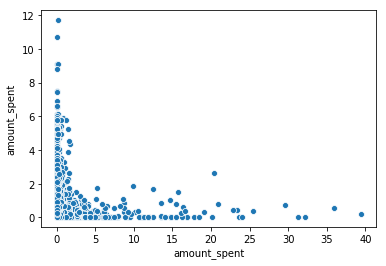

In [149]:
sns.scatterplot(x=train_label['amount_spent'], y=oof1_df2['amount_spent'])

In [150]:
# score_function.score_function(train_label, train_label, path=False)
score_function(train_label, train_label)

91693.76240883442

In [151]:
pred1_df = pd.DataFrame([char_ids_t1['acc_id'], char_ids_t1['char_id'], pred1_time.astype(int), pred1_spent]).T
pred1_df.columns = ['acc_id', 'char_id', 'survival_time', 'amount_spent']
pred1_df.head()

,acc_id,char_id,survival_time,amount_spent
0,7.0,39169.0,47.0,0.145825
3,7.0,252768.0,47.0,0.142367
4,7.0,255739.0,47.0,0.140374
5,15.0,144442.0,47.0,0.141034
9,15.0,147878.0,47.0,0.143301


In [0]:
pred1_df.loc[pred1_df['survival_time'].isnull()] = pred1_df.loc[pred1_df['survival_time'].isnull()].fillna(1)

In [0]:
pred1_df.loc[pred1_df['amount_spent'].isnull()] = pred1_df.loc[pred1_df['amount_spent'].isnull()].fillna(0)

In [0]:
pred1_df[['acc_id', 'char_id', 'survival_time']] = pred1_df[['acc_id', 'char_id', 'survival_time']].astype(int)

In [0]:
pred1_df_agg = pred1_df.groupby('acc_id').agg({'survival_time':'max', 'amount_spent':'max'}).reset_index()

### payment 평균으로 

In [0]:
pred1_df_agg2 = pd.merge(pred1_df_agg.drop('amount_spent', axis=1), test1_payment.groupby('acc_id')['amount_spent'].mean().reset_index(), on='acc_id', how='left').fillna(0)

In [0]:
pred1_df_agg2.to_csv('./drive/My Drive/bigcontest2019/scripts/model/HH/0826/test1_predict_d.csv', index=False, encoding='utf-8')

In [158]:
pred1_df_agg.head()

,acc_id,survival_time,amount_spent
0,7,47,0.145825
1,15,47,0.145559
2,16,47,0.177983
3,18,47,0.143301
4,19,47,0.147320


In [159]:
pred1_spent.max(), pred1_spent.min(), pred1_time.max(), pred1_time.min()

(0.32826148017244994,
 0.11090473006404636,
 48.30533442457498,
 45.30234654821912)

In [160]:
!ls

drive  sample_data  test2_predict.csv




유형 | 점수 |
---- | ---- |
W + D| 2798.97|
W    | 2807.73|
D    | 2802.8 |
# 결과리포트

## 